In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


In [16]:
def add_section(title, content):
    """Prints a section title and displays the content."""
    print(f"{title}:\n")
    display(content)
    print("---"*25)
    print("\n")

def assess_df(df):
    """Assesses a DataFrame by checking for nulls, unique values, duplicates, and descriptive statistics."""
    sections = [
        ("Null Values", df.isna().sum()),
        ("Unique Values", df.nunique()),
        ("Duplicate Rows", df.duplicated().sum()),
        ("Descriptive Statistics", df.describe()),
        ("Random Sample", df.sample(10))
    ]
    
    for title, content in sections:
        add_section(title, content)


def plot_features(data, ncols, fig_suptitle, figsize=(15,15), is_continuous=1, plot_type='box', **plot_kwargs):
    """
    Plots features using the specified plot type.

    Parameters:
    - data: DataFrame containing the features (features subset).
    - fig_suptitle: the title for the fig
    - plot_type: Type of plot ('box', 'hist', etc.).
    - **plot_kwargs: Additional keyword arguments passed to the plotting function.
    """
    num_features = data.shape[1]
    nrows = (num_features + ncols - 1) // ncols
    # base_width = 4
    # base_height = 3
    # figsize = (base_width * ncols, base_height * nrows)
    
    # Create subplots with a layout 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(pad=5.0)
    fig.suptitle(fig_suptitle, fontsize=16)

    # Flatten the 2D array of axes to make it easier to iterate over
    axes = axes.flatten()

    # Loop through each feature and plot it in the corresponding subplot
    for i, col in enumerate(data.columns):
        ax = axes[i]
        if is_continuous:
            data[col].plot(kind=plot_type, ax=ax, **plot_kwargs)
        else:
            data[col].value_counts().plot(kind=plot_type, ax=ax, **plot_kwargs)
        ax.set_title(col)
        # ax.set_xlabel('Value')

    # Remove any unused subplots (in case num_features < number of subplots)
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

# 1. Data prep & cleaning

In [3]:
df = pd.read_csv("housing_prices.csv")
df.head()

,Square_Feet,Bedrooms,Age,Location_Rating,Price
0,1360,2,11,7.017154,600672
1,4272,3,31,7.108030,560878
2,3592,1,95,4.257280,676665
3,966,1,91,6.342947,566043
4,4926,2,12,1.091181,593599


In [22]:
X = df.drop("Price", axis=1)
y = df["Price"]
print(X.shape, y.shape)

(1000, 4) (1000,)


In [13]:
assess_df(X)

Null Values:



Square_Feet        0
Bedrooms           0
Age                0
Location_Rating    0
dtype: int64

---------------------------------------------------------------------------


Unique Values:



Square_Feet         894
Bedrooms              5
Age                 100
Location_Rating    1000
dtype: int64

---------------------------------------------------------------------------


Duplicate Rows:



0

---------------------------------------------------------------------------


Descriptive Statistics:



,Square_Feet,Bedrooms,Age,Location_Rating
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2815.422000,2.990000,48.414000,5.483500
std,1255.514921,1.427564,29.183699,2.589672
min,503.000000,1.000000,0.000000,1.000105
25%,1749.500000,2.000000,22.000000,3.335411
50%,2862.500000,3.000000,47.000000,5.502313
75%,3849.500000,4.000000,74.000000,7.677870
max,4999.000000,5.000000,99.000000,9.980388


---------------------------------------------------------------------------


Random Sample:



,Square_Feet,Bedrooms,Age,Location_Rating
191,3869,4,67,7.664285
529,3203,3,42,8.023290
574,3256,4,78,3.726378
447,3640,2,83,6.125858
772,2469,5,77,1.123710
221,3369,2,88,3.091459
980,1414,5,46,7.765723
217,2700,5,72,1.452034
236,3946,2,46,8.997932
135,3945,5,59,3.481908


---------------------------------------------------------------------------




In [14]:
assess_df(y)

Null Values:



0

---------------------------------------------------------------------------


Unique Values:



999

---------------------------------------------------------------------------


Duplicate Rows:



1

---------------------------------------------------------------------------


Descriptive Statistics:



count    1.000000e+03
mean     6.044307e+05
std      1.814169e+05
min      1.087100e+05
25%      4.775332e+05
50%      6.003425e+05
75%      7.320828e+05
max      1.039240e+06
Name: Price, dtype: float64

---------------------------------------------------------------------------


Random Sample:



880    703124
559    383621
499    587599
505    563436
812    561351
578    812154
146    533096
823    314833
40     811764
261    647990
Name: Price, dtype: int64

---------------------------------------------------------------------------




## Some houses have Age of ZERO!
* remove
* replace
* impute
* new category unknown

In [37]:
df.Age[df.Age == 0]

115    0
150    0
286    0
435    0
632    0
646    0
729    0
892    0
957    0
Name: Age, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split


X = df.drop("Price", axis=1)
y = df["Price"]
print(X.shape, y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
print("Train split shape:", X_train.shape, y_train.shape)
print("Validation split shape:", X_val.shape, y_val.shape)
print("Test split shape:", X_test.shape, y_test.shape)

(1000, 4) (1000,)
Train split shape: (700, 4) (700,)
Validation split shape: (150, 4) (150,)
Test split shape: (150, 4) (150,)


In [53]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.50946051 0.53544404 0.35805482 0.48424388 0.47817587]
Mean CV score: 0.47307582418261146


In [54]:
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [55]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Perform cross-validation with remove Age = 0
cv_scores = cross_val_score(pipeline, X_train[X_train['Age'] != 0], y_train[X_train['Age'] != 0], cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.5066591  0.53045813 0.34983869 0.49281978 0.48518604]
Mean CV score: 0.47299234550629493


In [57]:
# Create a copy of X_train and fill NaN values in the Age column with zeros
X_train_copy = X_train.copy()
X_train_copy['Age'].fillna(0, inplace=True)

# Create pipelines for mean and median imputation
mean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute Age with mean
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute Age with median
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Perform cross-validation on both pipelines
mean_cv_scores = cross_val_score(mean_pipeline, X_train_copy, y_train, cv=5)
median_cv_scores = cross_val_score(median_pipeline, X_train_copy, y_train, cv=5)

# Print the cross-validation scores
print("Mean Imputation Cross-validation scores:", mean_cv_scores)
print("Mean CV score:", mean_cv_scores.mean())
print("Median Imputation Cross-validation scores:", median_cv_scores)
print("Median CV score:", median_cv_scores.mean())

Mean Imputation Cross-validation scores: [0.50946051 0.53544404 0.35805482 0.48424388 0.47817587]
Mean CV score: 0.47307582418261146
Median Imputation Cross-validation scores: [0.50946051 0.53544404 0.35805482 0.48424388 0.47817587]
Median CV score: 0.47307582418261146


## Not that much difference!


## EDA

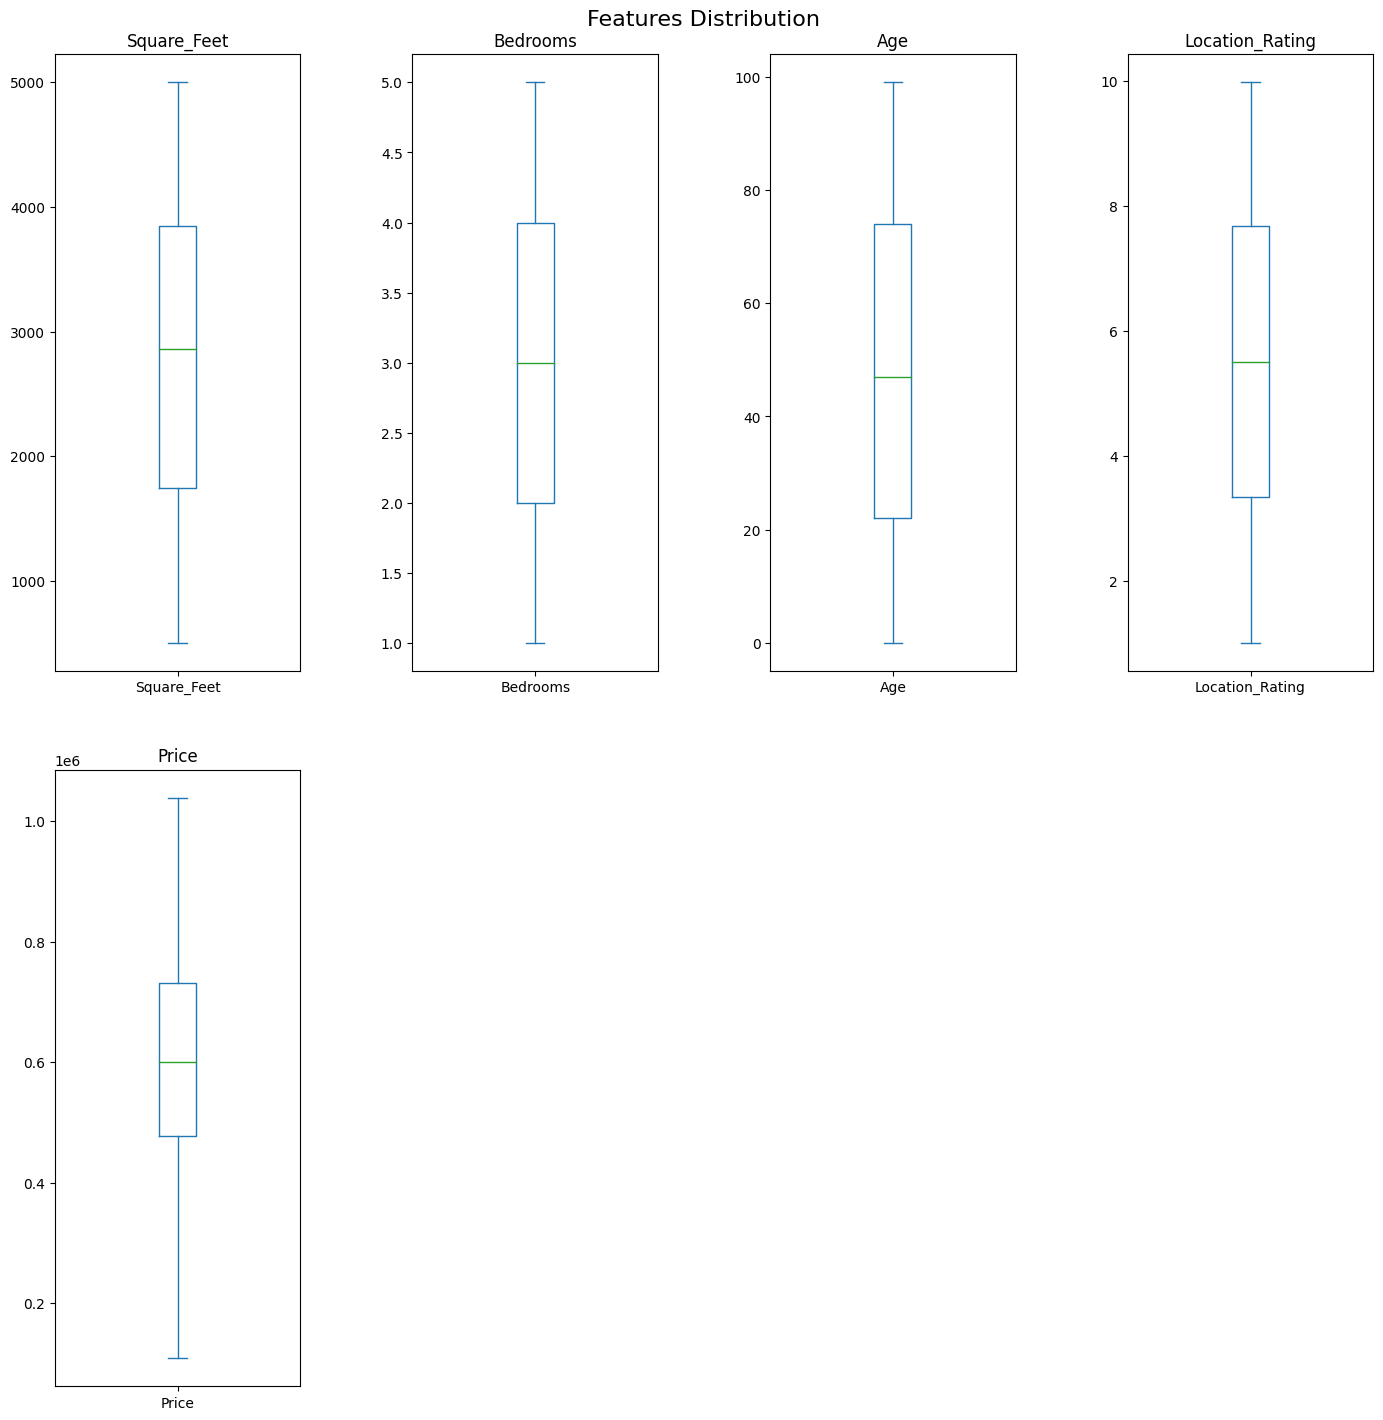

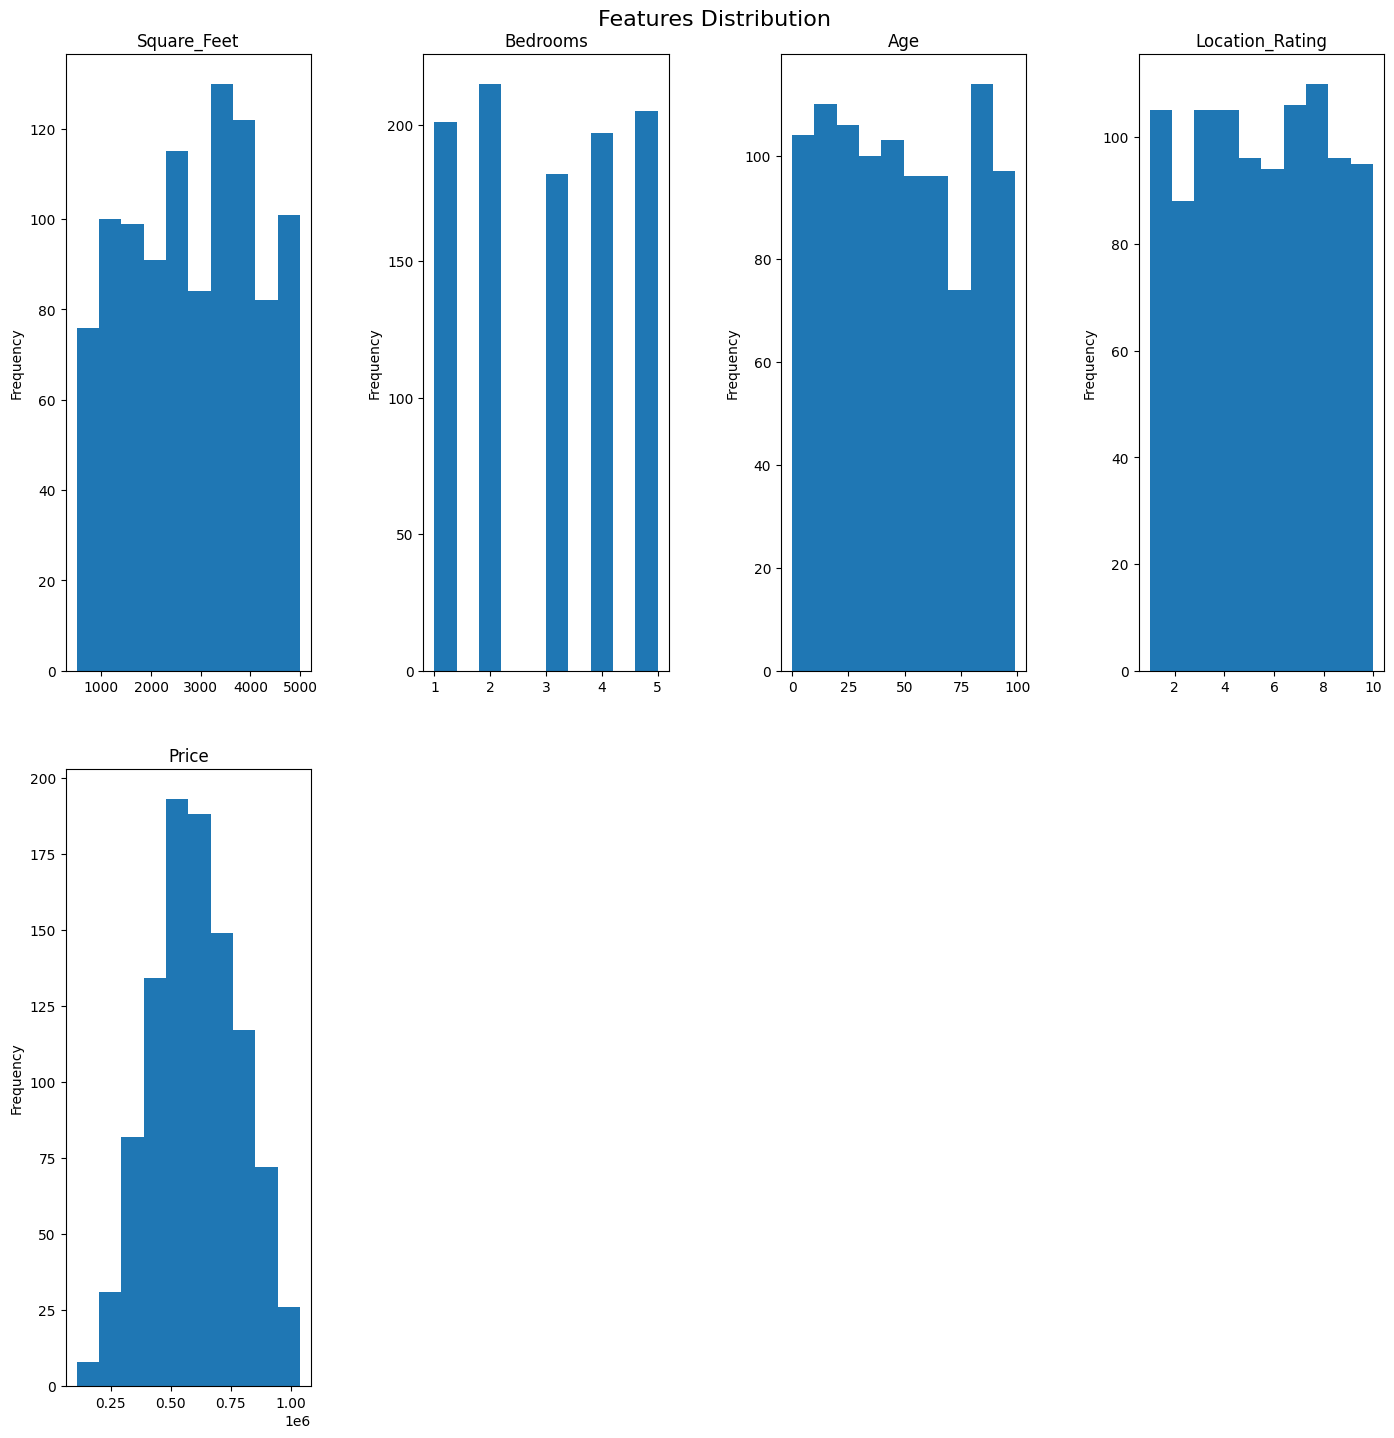

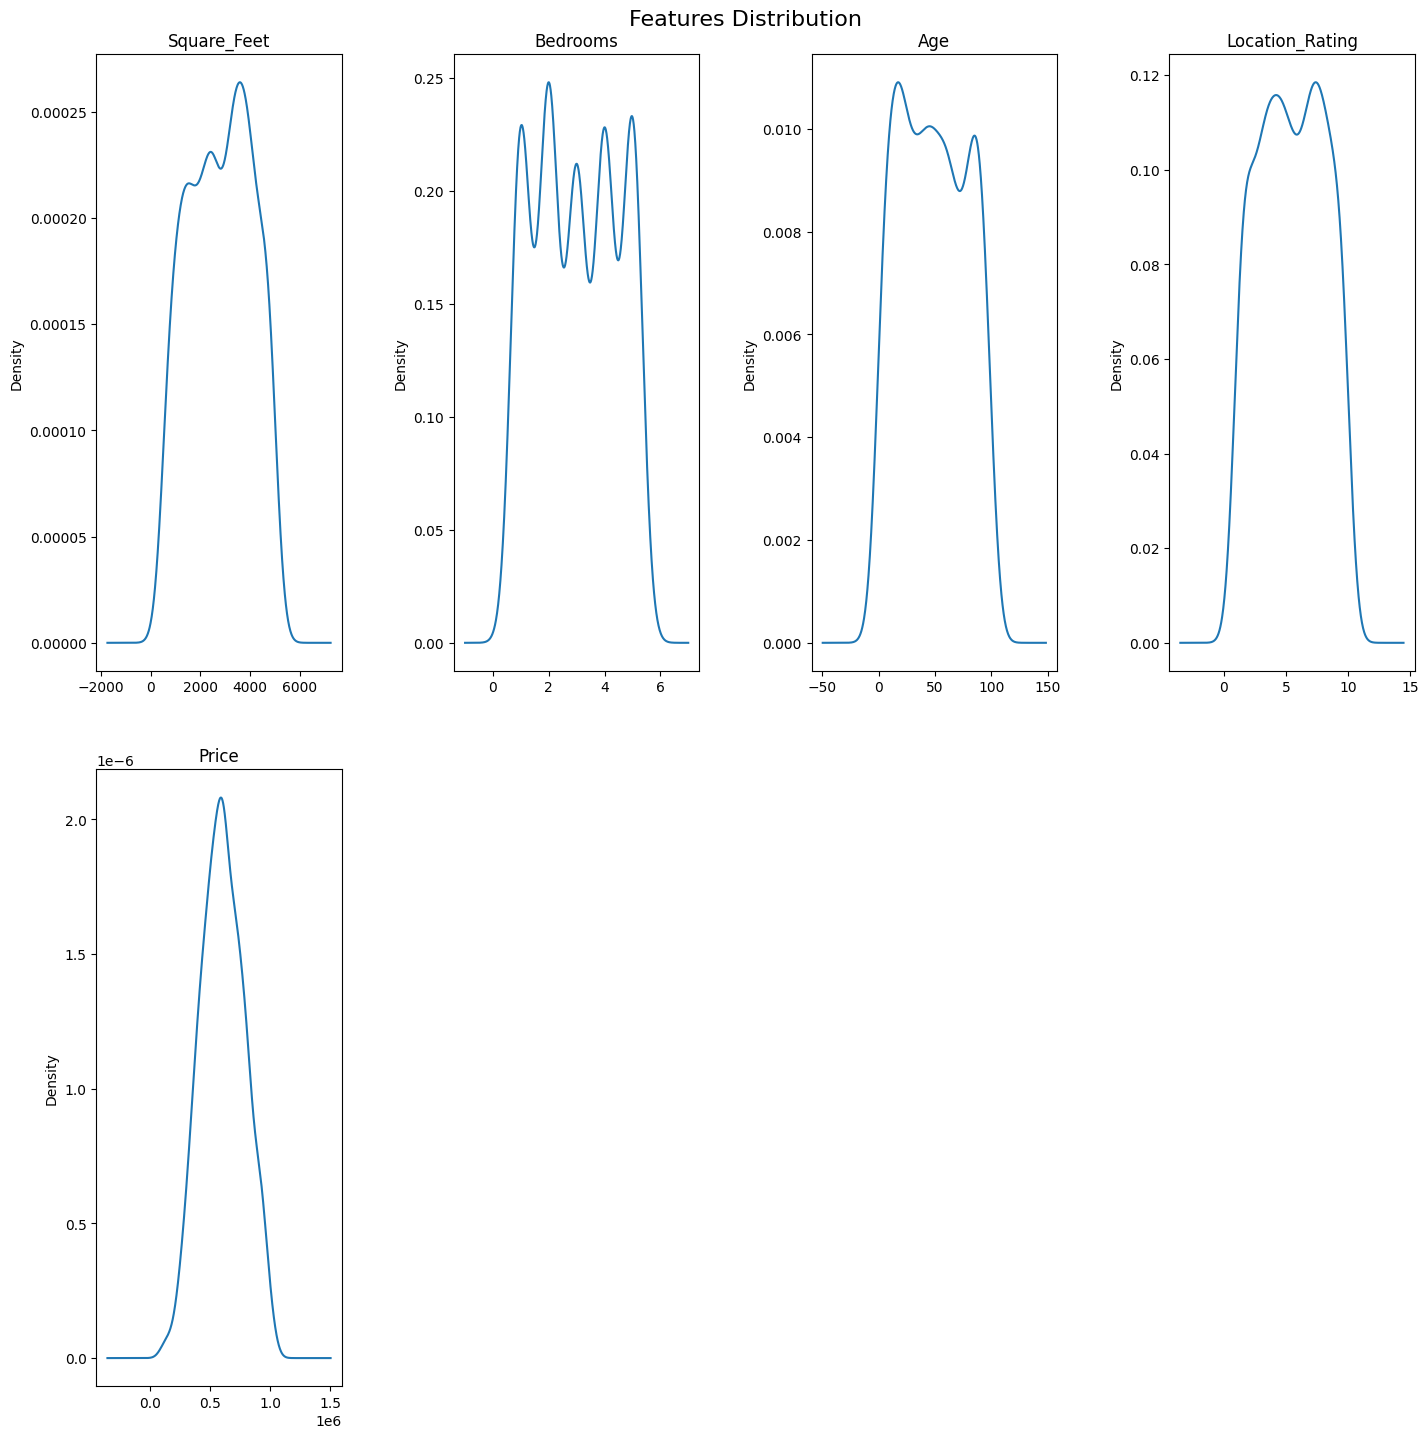

In [18]:
for plot_type in ['box', 'hist', 'density']:
    plot_features(df[df.columns], 
                ncols=4, fig_suptitle='Features Distribution', figsize=(15,15), is_continuous=1, plot_type=plot_type)

# 2. Feature selection

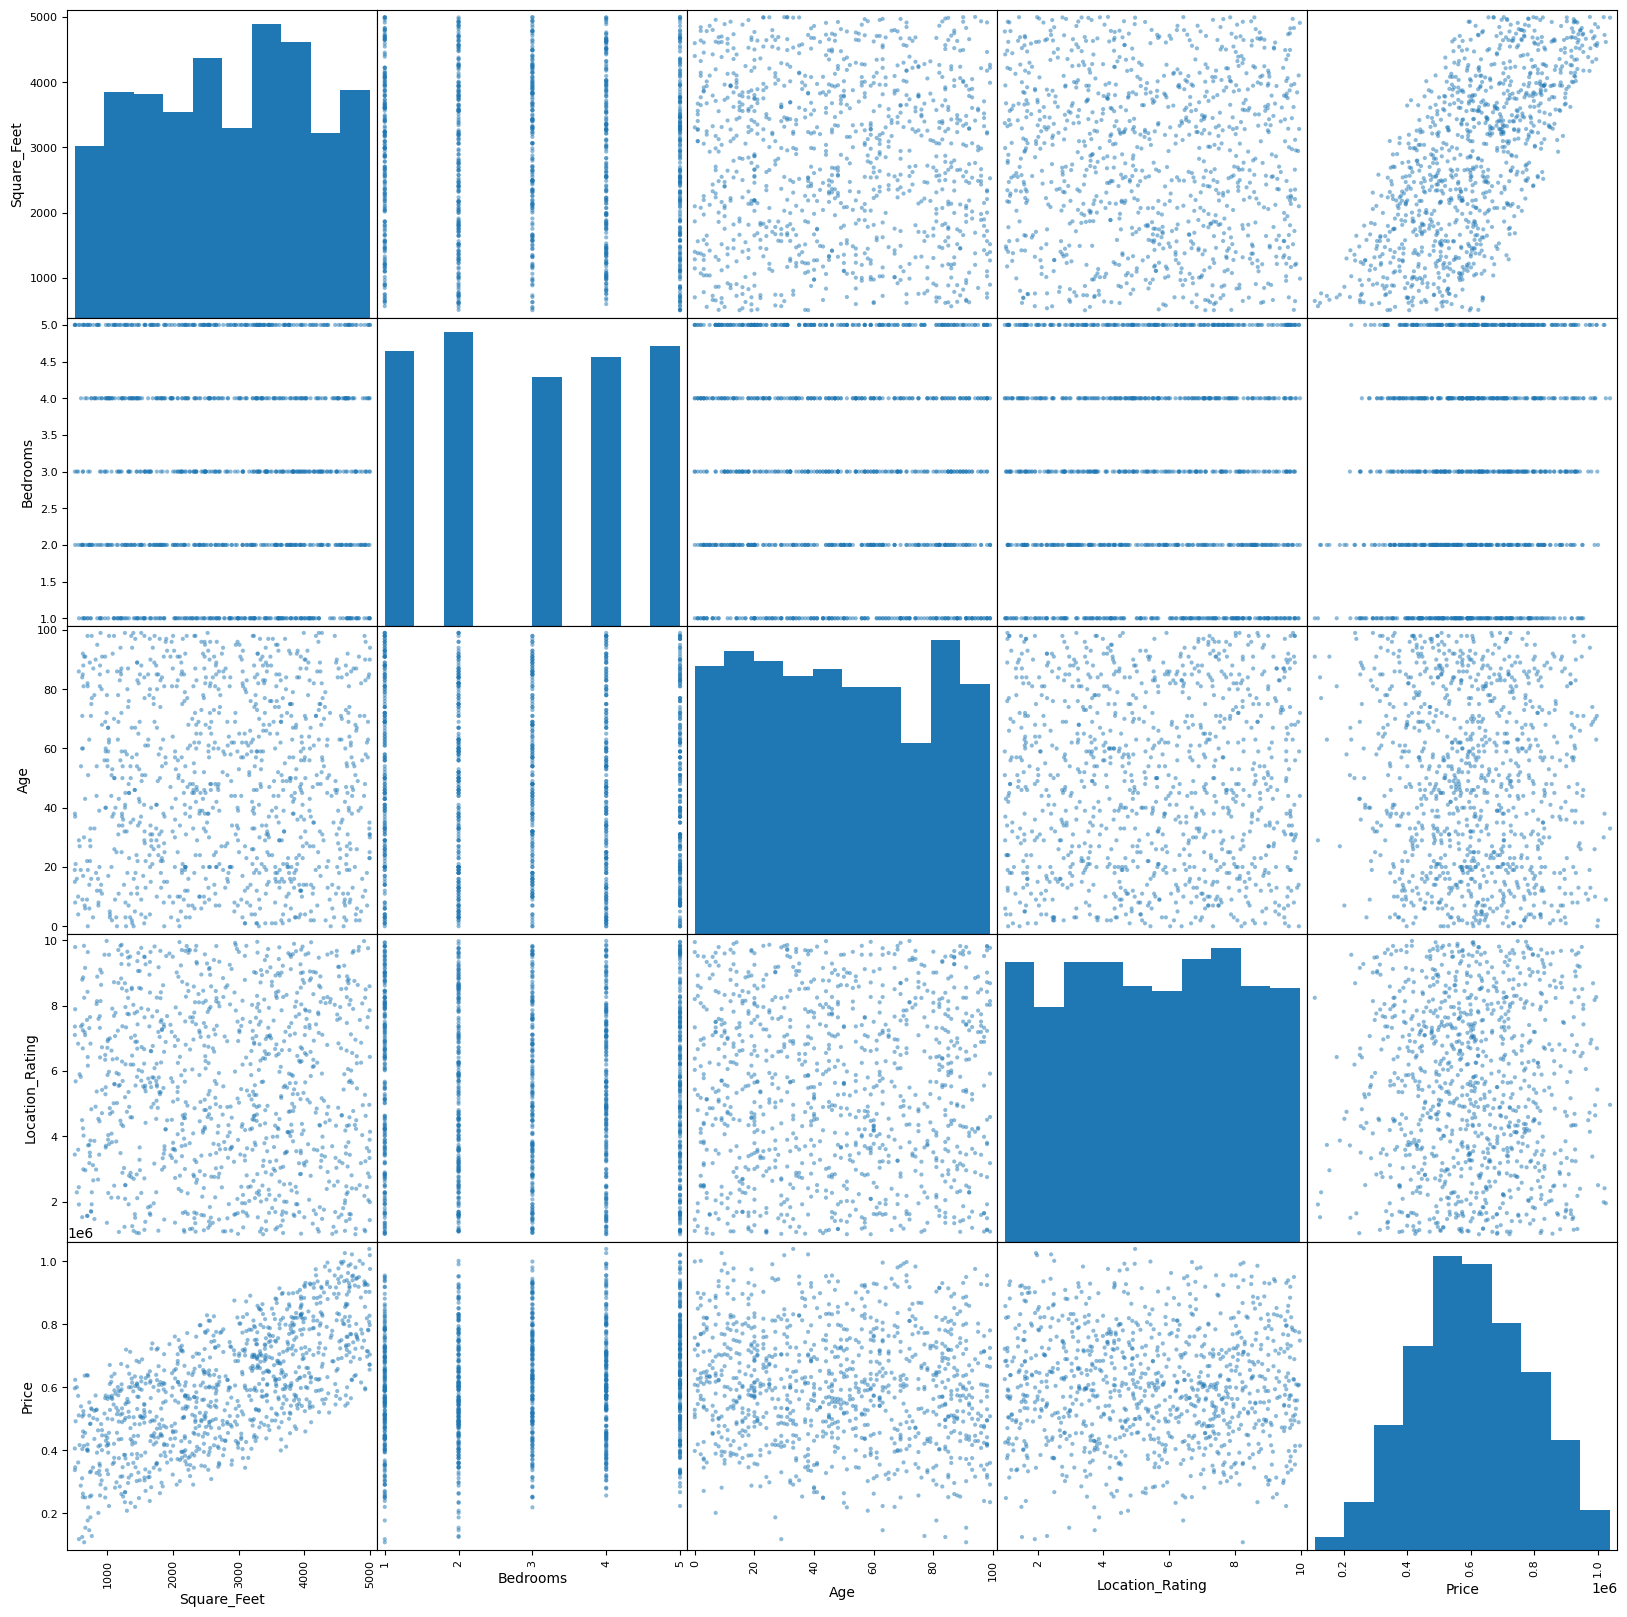

In [20]:
pd.plotting.scatter_matrix(df[df.columns], figsize=(20,20));

In [26]:
df.head()

,Square_Feet,Bedrooms,Age,Location_Rating,Price
0,1360,2,11,7.017154,600672
1,4272,3,31,7.108030,560878
2,3592,1,95,4.257280,676665
3,966,1,91,6.342947,566043
4,4926,2,12,1.091181,593599


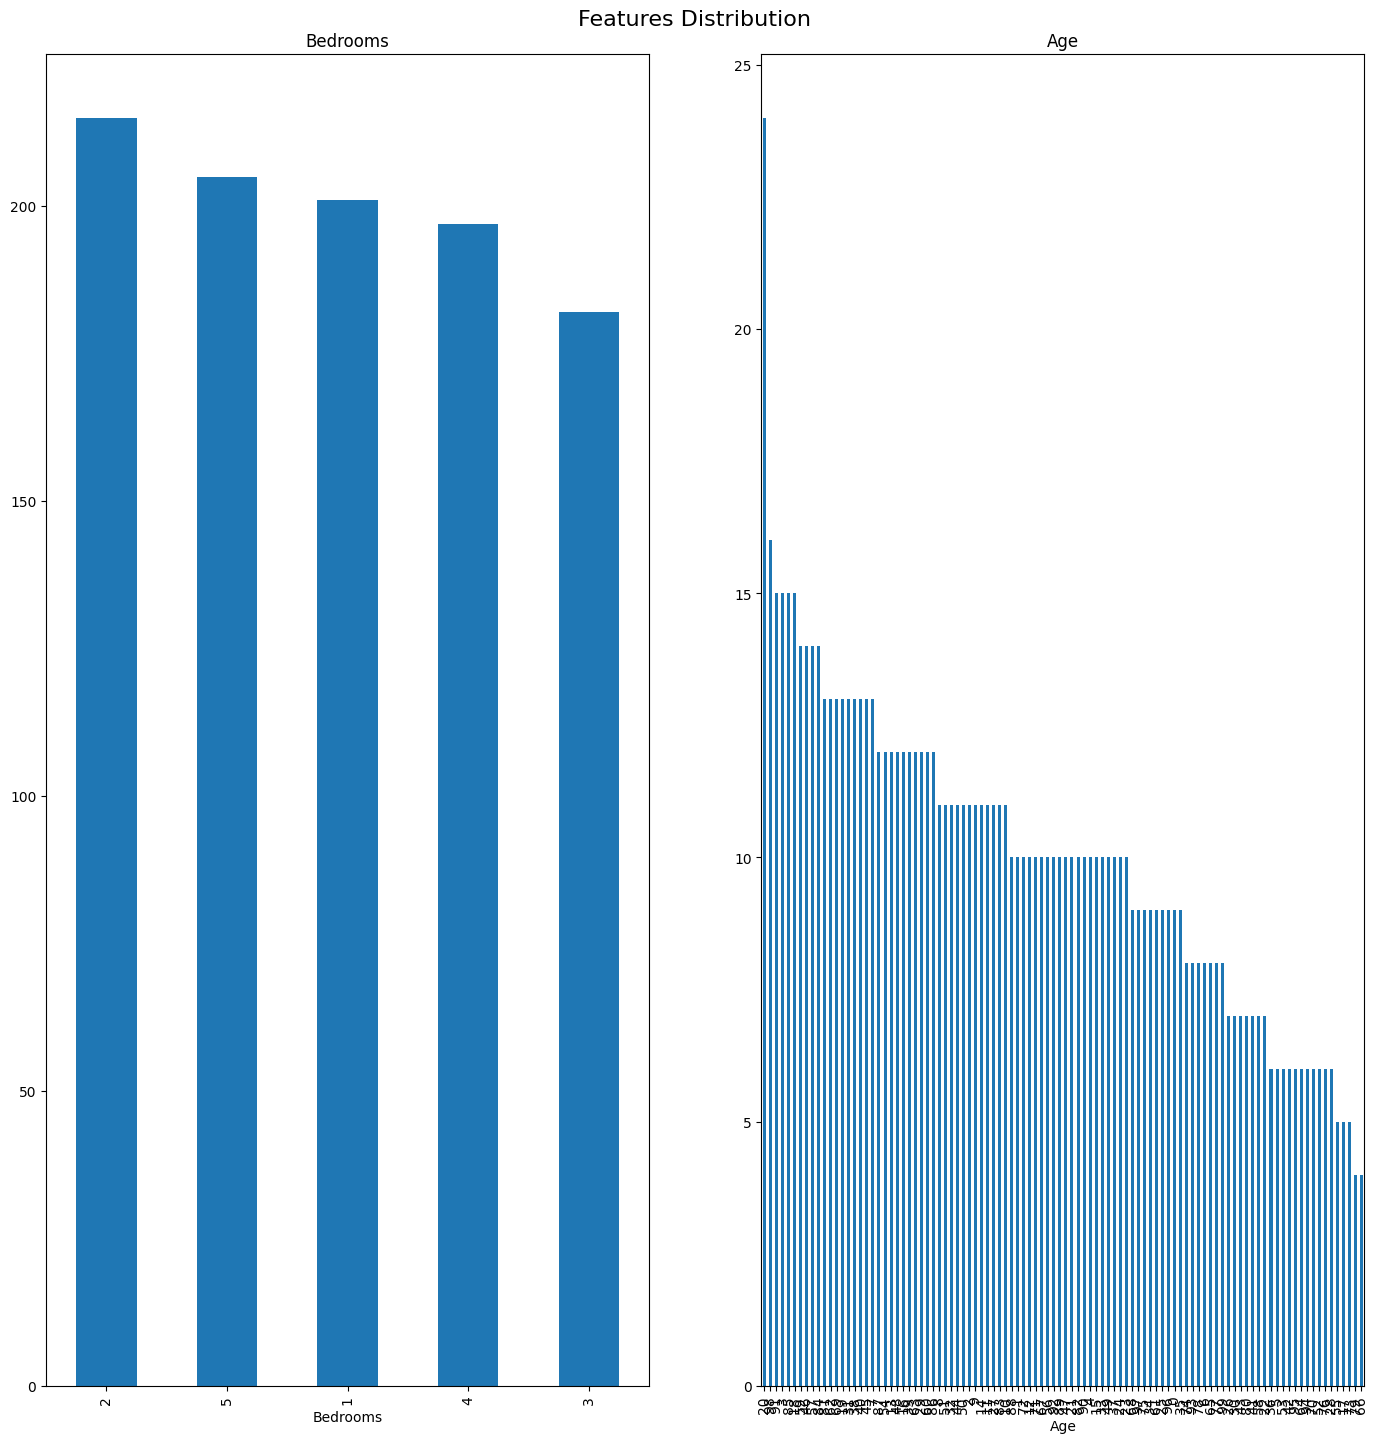

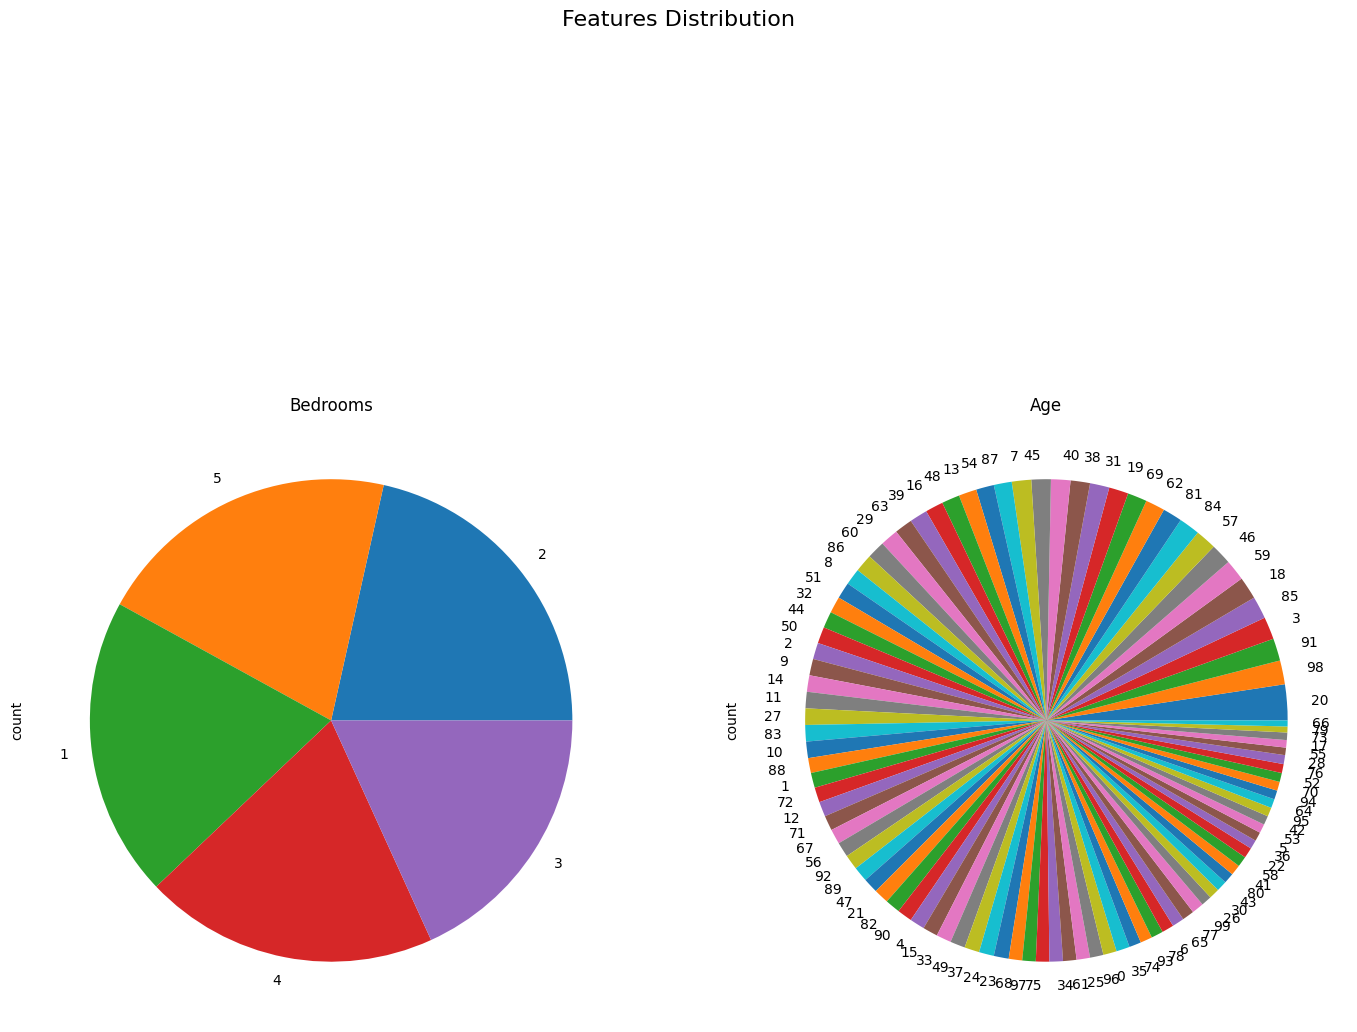

In [35]:
for plot_type in ['bar', 'pie']:
    plot_features(df[["Bedrooms", "Age"]].astype(object), 
                ncols=2, fig_suptitle='Features Distribution', figsize=(15,15), is_continuous=0, plot_type=plot_type)

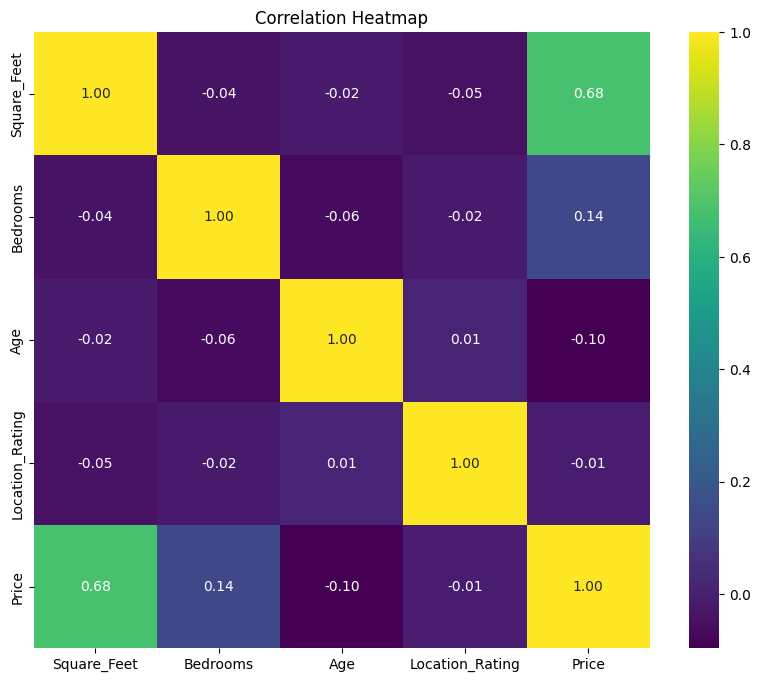

In [21]:
import seaborn as sns

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', cbar=True, square=True)

plt.title('Correlation Heatmap')
plt.show();

In [15]:
df.corr()

,Square_Feet,Bedrooms,Age,Location_Rating,Price
Square_Feet,1.000000,-0.043564,-0.017374,-0.047750,0.681525
Bedrooms,-0.043564,1.000000,-0.064413,-0.021984,0.140972
Age,-0.017374,-0.064413,1.000000,0.011240,-0.096490
Location_Rating,-0.047750,-0.021984,0.011240,1.000000,-0.013185
Price,0.681525,0.140972,-0.096490,-0.013185,1.000000


# 3. Data splitting

In [24]:
from sklearn.model_selection import train_test_split


X = df.drop("Price", axis=1)
y = df["Price"]
print(X.shape, y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
print("Train split shape:", X_train.shape, y_train.shape)
print("Validation split shape:", X_val.shape, y_val.shape)
print("Test split shape:", X_test.shape, y_test.shape)

(1000, 4) (1000,)
Train split shape: (700, 4) (700,)
Validation split shape: (150, 4) (150,)
Test split shape: (150, 4) (150,)


# 4. Model building and training

In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Split the data
X = df.drop("Price", axis=1)
y = df["Price"]
print(X.shape, y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
print("Train split shape:", X_train.shape, y_train.shape)
print("Validation split shape:", X_val.shape, y_val.shape)
print("Test split shape:", X_test.shape, y_test.shape)

X_train_nn = X_train.values
X_val_nn = X_val.values
X_test_nn = X_test.values  
y_train_nn = y_train.values 
y_val_nn = y_val.values 

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_nn)
X_val = scaler.transform(X_val_nn)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_nn)
y_train_tensor = torch.FloatTensor(y_train_nn).view(-1, 1)  # Reshape for a single output
X_val_tensor = torch.FloatTensor(X_val_nn)
y_val_tensor = torch.FloatTensor(y_val_nn).view(-1, 1)

# Define the Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # Input layer to hidden layer
        self.fc2 = nn.Linear(64, 32)  # Hidden layer
        self.fc3 = nn.Linear(32, 1)  # Hidden layer to output layer
        self.activation = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

# Set up Loss Function and Optimizer
model = SimpleNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Print loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    val_loss = criterion(y_val_pred, y_val_tensor)

print(f'Validation Loss: {val_loss.item():.4f}')

(1000, 4) (1000,)
Train split shape: (700, 4) (700,)
Validation split shape: (150, 4) (150,)
Test split shape: (150, 4) (150,)
Epoch [1/20], Loss: 401863278592.0000
Epoch [2/20], Loss: 401831297024.0000
Epoch [3/20], Loss: 401799380992.0000
Epoch [4/20], Loss: 401768710144.0000
Epoch [5/20], Loss: 401738956800.0000
Epoch [6/20], Loss: 401709203456.0000
Epoch [7/20], Loss: 401679253504.0000
Epoch [8/20], Loss: 401649008640.0000
Epoch [9/20], Loss: 401618567168.0000
Epoch [10/20], Loss: 401587798016.0000
Epoch [11/20], Loss: 401556635648.0000
Epoch [12/20], Loss: 401525309440.0000
Epoch [13/20], Loss: 401497325568.0000
Epoch [14/20], Loss: 401469177856.0000
Epoch [15/20], Loss: 401440505856.0000
Epoch [16/20], Loss: 401411342336.0000
Epoch [17/20], Loss: 401382146048.0000
Epoch [18/20], Loss: 401353768960.0000
Epoch [19/20], Loss: 401324670976.0000
Epoch [20/20], Loss: 401294884864.0000
Validation Loss: 401173938176.0000


In [59]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5, max_leaf_nodes=20))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.36105643 0.50795776 0.24710298 0.33637681 0.41303906]
Mean CV score: 0.3731066069646317


In [62]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 DecisionTreeRegressor(max_depth=10, max_leaf_nodes=20,
                                       min_samples_split=5, random_state=42))])

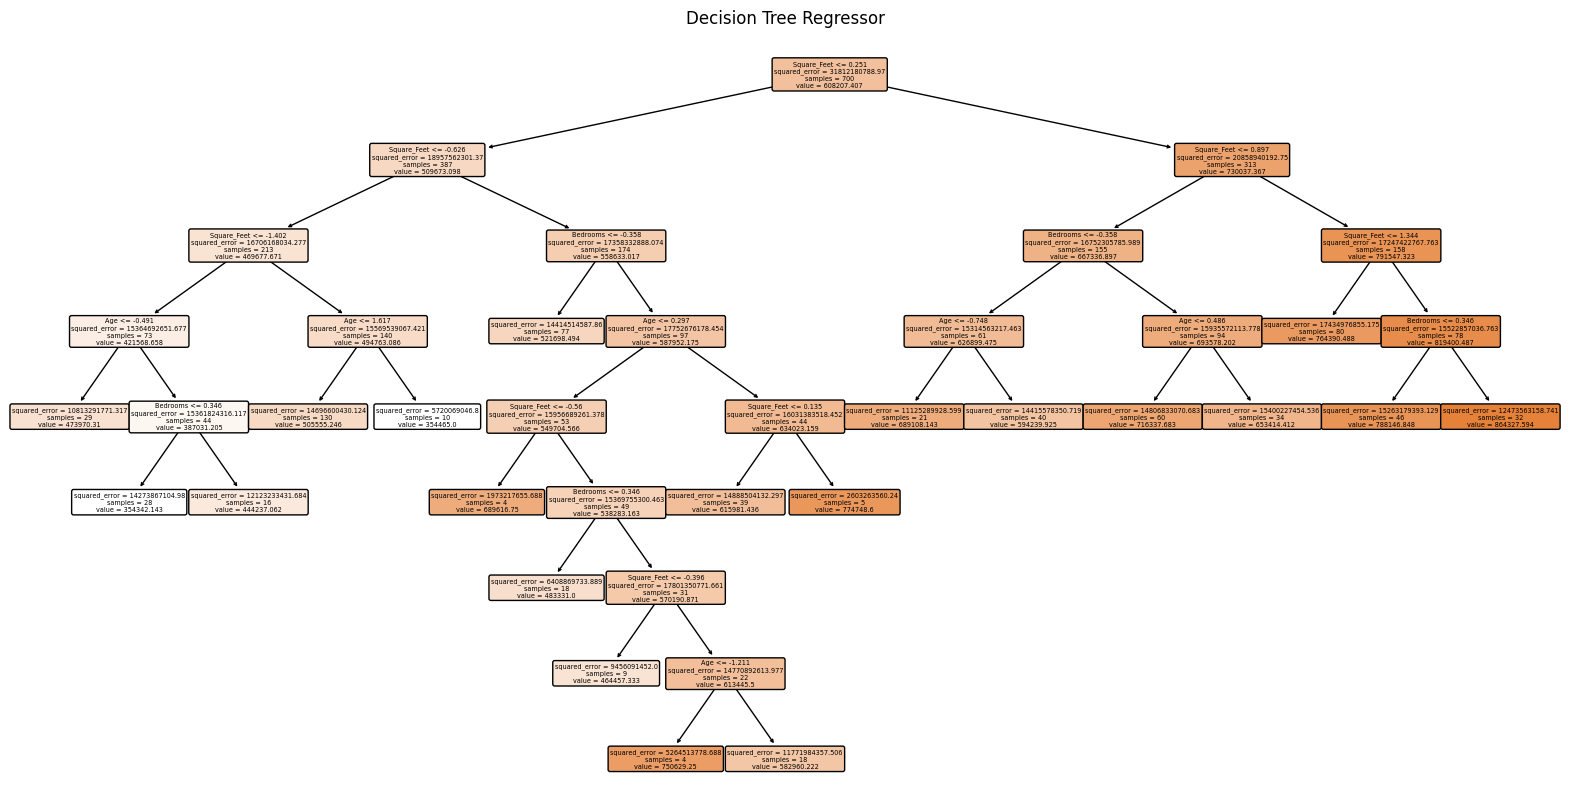

In [63]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(pipeline.named_steps['regressor'], 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True)
plt.title('Decision Tree Regressor')
plt.show()

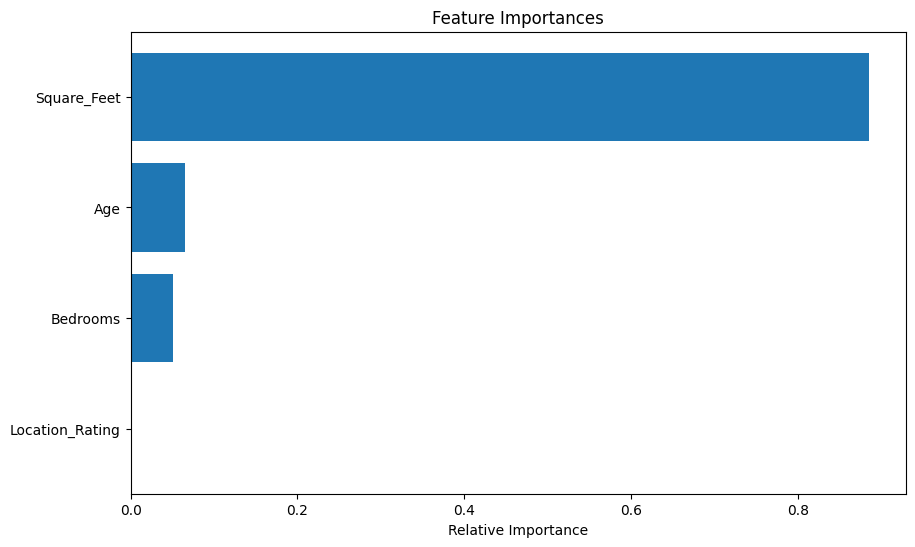

In [65]:
# Get feature importances
importances = pipeline.named_steps['regressor'].feature_importances_

# Get the feature names
feature_names = X_train.columns

# Create a sorted index of feature importances
indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Relative Importance")
plt.show()

# 5. Model Testing and Output Accuracy

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
explained_variance = explained_variance_score(y_val, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"1. Mean Absolute Error (MAE): {mae:.4f}")
print(f"2. Mean Squared Error (MSE): {mse:.4f}")
print(f"3. Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"4. R² Score: {r2:.4f}")
print(f"5. Explained Variance Score: {explained_variance:.4f}")

Evaluation Metrics:
1. Mean Absolute Error (MAE): 124905.1945
2. Mean Squared Error (MSE): 21357895254.1764
3. Root Mean Squared Error (RMSE): 146143.4065
4. R² Score: 0.3871
5. Explained Variance Score: 0.4023


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"1. Mean Absolute Error (MAE): {mae:.4f}")
print(f"2. Mean Squared Error (MSE): {mse:.4f}")
print(f"3. Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"4. R² Score: {r2:.4f}")
print(f"5. Explained Variance Score: {explained_variance:.4f}")

Evaluation Metrics:
1. Mean Absolute Error (MAE): 117504.8653
2. Mean Squared Error (MSE): 19952413339.4013
3. Root Mean Squared Error (RMSE): 141253.0118
4. R² Score: 0.4375
5. Explained Variance Score: 0.4536
